In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import solve_ivp

## Latent PKPD Model

In [49]:
def latent_variable(t, phi):
    """ Compute the polynomial latent variable Q(t) based on the given parameters. """
    return sum(phi[i] * (t ** i) for i in range(len(phi)))

def pkpd_model(t, y, params, phi):
    C, x = y  # Drug concentration and cancer volume
    k_elim, k_growth, k_drug_effect = params

    # Compute the latent variable Q(t)
    Q = latent_variable(t, phi)

    # Drug administration modeled as Bernoulli process (0 or 1)
    a_t = np.random.binomial(1, 0.5)  # Probability of administering drug at time t

    # Define the rate equations
    dCdt = -k_elim * C + (a_t * 5)  # Drug concentration change
    dXdt = k_growth * x * (1 - (x / 100)) + Q - k_drug_effect * a_t * C  # Cancer volume change influenced by Q

    return [dCdt, dXdt]

In [50]:
def generate_pkpd_data(num_individuals, population_params, phi, t):
    results_concentration = []
    results_volume = []

    for _ in range(num_individuals):
        y0 = [10, 1]  # Initial drug concentration and cancer volume
        # Solve ODE using solve_ivp
        res = solve_ivp(pkpd_model, [t[0], t[-1]], y0, args=(population_params, phi), t_eval=t)
        results_concentration.append(res.y[0])
        results_volume.append(res.y[1])

    results_concentration = np.array(results_concentration)
    results_volume = np.array(results_volume)

    mean_concentration = np.mean(results_concentration, axis=0)
    mean_volume = gaussian_filter1d(np.mean(results_volume, axis=0), sigma=2)

    # Calculate latent variables for visualization
    latent_values = latent_variable(t, phi)

    return results_concentration, results_volume, mean_concentration, mean_volume, latent_values

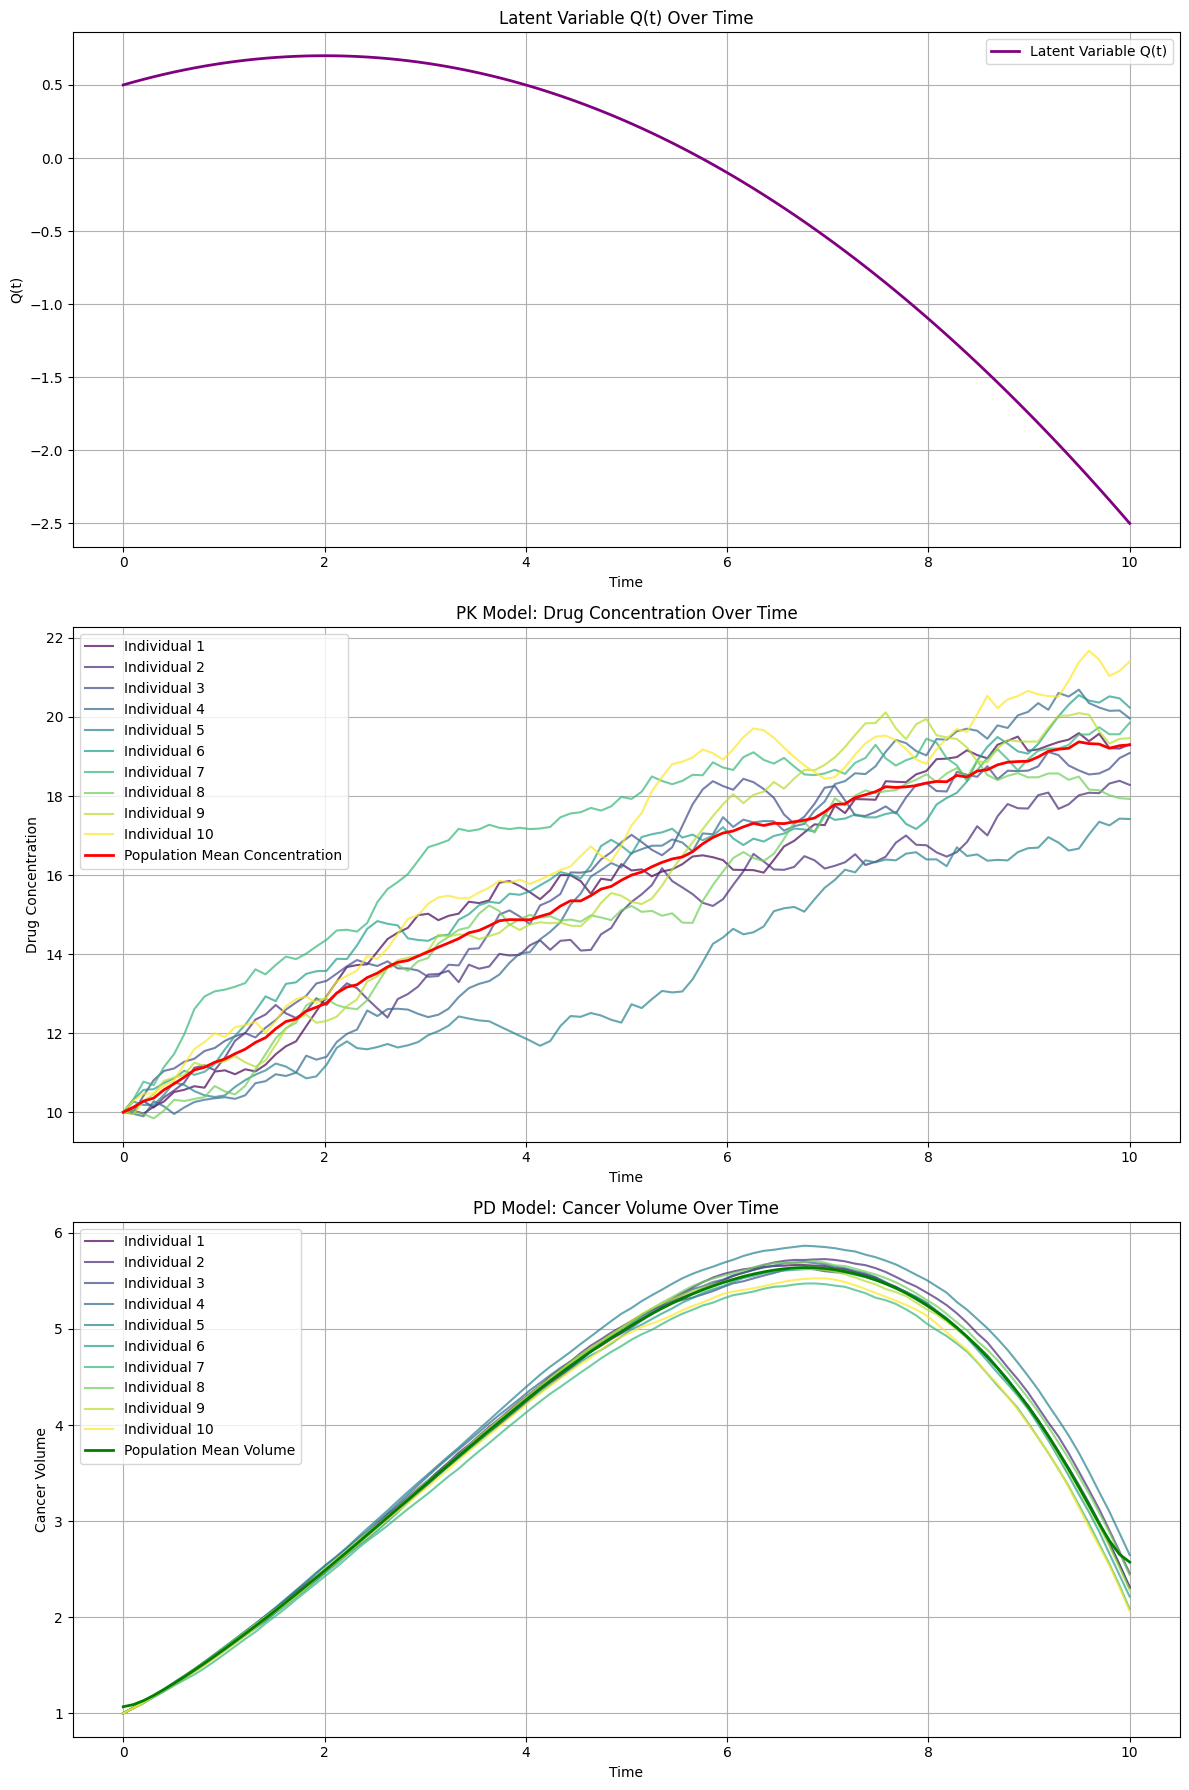

In [51]:
# Example Parameters
population_parameters = (0.1, 0.1, 0.01)  # k_elim, k_growth, k_drug_effect
time_points = np.linspace(0, 10, 100)  # Time points for the simulation

# Latent variable polynomial coefficients (change degree as needed)
phi = [0.5, 0.2, -0.05]  # Example coefficients for Q(t) = 0.5 + 0.2*t - 0.05*t^2 (quadratic)

# Generate Data
num_individuals = 10
data = generate_pkpd_data(num_individuals, population_parameters, phi, time_points)
results_concentration, results_volume, mean_concentration, mean_volume, latent_values = data

# Color map for individual plots
colors = plt.cm.viridis(np.linspace(0, 1, num_individuals))

# Plotting the results
plt.figure(figsize=(12, 18))

# Plot Latent Variable Q(t)
plt.subplot(3, 1, 1)
plt.plot(time_points, latent_values, color='purple', linewidth=2, label='Latent Variable Q(t)')
plt.title('Latent Variable Q(t) Over Time')
plt.xlabel('Time')
plt.ylabel('Q(t)')
plt.legend()
plt.grid()

# Plot Drug Concentration
plt.subplot(3, 1, 2)
for i, concentration in enumerate(results_concentration):
    plt.plot(time_points, concentration, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

plt.plot(time_points, mean_concentration, color='red', linewidth=2, label='Population Mean Concentration')
plt.title('PK Model: Drug Concentration Over Time')
plt.xlabel('Time')
plt.ylabel('Drug Concentration')
plt.legend()
plt.grid()

# Plot Cancer Volume
plt.subplot(3, 1, 3)
for i, volume in enumerate(results_volume):
    plt.plot(time_points, volume, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

plt.plot(time_points, mean_volume, color='green', linewidth=2, label='Population Mean Volume')
plt.title('PD Model: Cancer Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Cancer Volume')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Fit VL-INSITE model

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import Lasso
from scipy.optimize import minimize


# Fit polynomial latent dynamics for each individual's concentration
def fit_latent_dynamics(t, Z, degree):
    """Fit polynomial coefficients for latent dynamics."""
    T = np.vstack([t**k for k in range(degree + 1)]).T
    coeffs = np.linalg.lstsq(T, Z, rcond=None)[0]
    return coeffs

# Build feature library for SINDy
def build_feature_library(X, Z):
    A = np.column_stack([X, Z, X * Z, X**2, Z**2])
    return A


# Fit sparse regression model for F
def fit_population_dynamics(t, dX_dt, feature_library):
    lasso = Lasso(alpha=0.01, fit_intercept=False)
    lasso.fit(feature_library, dX_dt)
    return lasso.coef_

# Example Parameters
population_parameters = (0.1, 0.1, 0.01)  # k_elim, k_growth, k_drug_effect
time_points = np.linspace(0, 10, 100)  # Time points for the simulation

# Latent variable polynomial coefficients (change degree as needed)
phi = [0.5, 0.2, -0.05]  # Example coefficients for Q(t) = 0.5 + 0.2*t - 0.05*t^2 (quadratic)

# Generate Data
n_individuals = 10
results_c, results_v, _, _, _ = generate_pkpd_data(n_individuals, population_parameters, phi, time_points)

# Fit latent dynamics for the concentration of each individual
latent_coeffs_list = []
for i in range(n_individuals):
    latent_coeffs = fit_latent_dynamics(time_points, results_c[i], degree=2)
    latent_coeffs_list.append(latent_coeffs)
    #print(f"Individual {i + 1} latent coefficients: {latent_coeffs}")

# After fitting latent dynamics, we need to build the feature library and calculate dX/dt
# Now we will concatenate results_c and results_v for use in modeling
independent_var = np.array(results_c).flatten()  # Drug concentrations
dependent_var = np.array(results_v).flatten()    # Cancer volumes

# Calculate dX/dt using finite differences for the combined dataset
dX_dt = np.array([np.gradient(results_v[i], time_points) for i in range(n_individuals)])

# Build the feature library using the combined dataset
feature_libraries = [build_feature_library(results_c[i], results_v[i]) for i in range(n_individuals)]
#feature_libraries = [build_feature_library_latent(results_c[i], results_v[i], latent_variable(time_points, latent_coeffs_list[i])) for i in range(n_individuals)]

# Calculate dX/dt for each individual
individual_dX_dt = [np.gradient(results_v[i], time_points) for i in range(n_individuals)]

# Fit the population-level ODE for the first individual as a reference
beta_est = fit_population_dynamics(time_points, individual_dX_dt[0], feature_libraries[0])

/home/users/bruno.cesar/miniconda3/envs/causal/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.323e+00, tolerance: 8.757e-03
  model = cd_fast.enet_coordinate_descent(


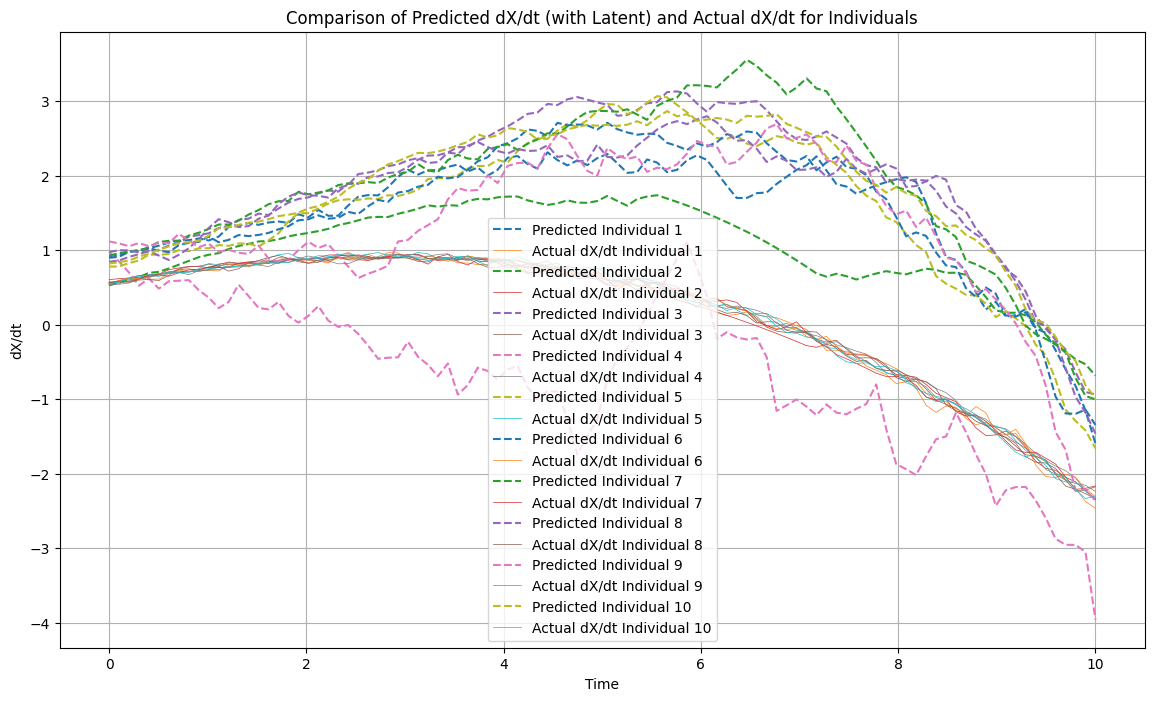

In [53]:
# Incorporate Latent Variables in Prediction
def latent_variable(t, phi):
    """Compute the polynomial latent variable Q(t) based on the given parameters."""
    return sum(phi[i] * (t ** i) for i in range(len(phi)))

# Fine-tune for individual-specific dynamics using their fitted latent coefficients
def fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library, beta_est, lambda_reg=0.1):
    def loss_function(beta_i):
        mse_loss = np.mean((dX_dt_i - feature_library @ beta_i) ** 2)
        reg_loss = lambda_reg * np.sum((beta_est - beta_i) ** 2)
        return mse_loss + reg_loss

    res = minimize(loss_function, beta_est, method="L-BFGS-B")
    return res.x

# Modify the predict_dX_dt function to include latent influence
def predict_dX_dt(X, V, individual_betas):
    dX_dt_predictions = []
    for i, beta_individual in enumerate(individual_betas):
        # Use the respective X[i] and V[i] for each individual
        dX_dt_i = (beta_individual[0] * X[i] * (1 - X[i] / 10) +
                    beta_individual[1] * V +
                    beta_individual[2] * np.sin(np.array(time_points)))
        
        dX_dt_predictions.append(dX_dt_i)
    
    return np.array(dX_dt_predictions)  # This should result in shape (10, 100)

# Fine-tune beta for each individual
individual_betas = []
for i in range(n_individuals):
    # Extract individual data
    X_i = results_c[i]  # Individual drug concentration
    Z_i = results_v[i]  # Individual cancer volume
    dX_dt_i = np.gradient(Z_i, time_points)  # Calculate individual dX/dt

    # Build feature library for the individual
    feature_library_i = build_feature_library(X_i, Z_i)

    # Fine-tune beta for the individual
    beta_individual = fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library_i, beta_est)
    individual_betas.append(beta_individual)

# Predict dX/dt for all individuals using their inferred betas
V = np.mean(results_v, axis=0)  # Average cancer volume across individuals
# Predict dX/dt for all individuals using their inferred betas
dX_dt_predicted = predict_dX_dt(results_c, V, individual_betas)

# Visualize predicted vs actual dX/d    t
plt.figure(figsize=(14, 8))

for i in range(n_individuals):
    plt.plot(time_points, dX_dt_predicted[i], label=f"Predicted Individual {i + 1}", linestyle='--')
    plt.plot(time_points, np.gradient(results_v[i], time_points), label=f"Actual dX/dt Individual {i + 1}", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("dX/dt")
plt.title("Comparison of Predicted dX/dt (with Latent) and Actual dX/dt for Individuals")
plt.legend()
plt.grid()
plt.show()

In [54]:
# Function to calculate Mean Squared Error
def calculate_mse(true_values, predicted_values):
    return np.mean((true_values - predicted_values) ** 2)

# Function to calculate R² (Goodness-of-Fit)
def calculate_r_squared(true_values, predicted_values):
    ss_res = np.sum((true_values - predicted_values) ** 2)  # Residual sum of squares
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)  # R² value

# After predicting dX/dt for all individuals, compute metrics
mse_values = []
r_squared_values = []

for i in range(n_individuals):
    mse = calculate_mse(individual_dX_dt[i], dX_dt_predicted[i])
    r_squared = calculate_r_squared(individual_dX_dt[i], dX_dt_predicted[i])
    mse_values.append(mse)
    r_squared_values.append(r_squared)

# Print the MSE and R² for each individual
for i in range(n_individuals):
    print(f"Individual {i + 1} - MSE: {mse_values[i]:.4f}, R²: {r_squared_values[i]:.4f}")

# Calculate population-level metrics
population_mse = calculate_mse(np.mean(individual_dX_dt, axis=0), np.mean(dX_dt_predicted, axis=0))
population_r_squared = calculate_r_squared(np.mean(individual_dX_dt, axis=0), np.mean(dX_dt_predicted, axis=0))

# Print population metrics
print(f"Population - MSE: {population_mse:.4f}, R²: {population_r_squared:.4f}")

Individual 1 - MSE: 2.3177, R²: -1.6867
Individual 2 - MSE: 1.1581, R²: -0.3545
Individual 3 - MSE: 3.9423, R²: -3.5743
Individual 4 - MSE: 1.0507, R²: -0.2817
Individual 5 - MSE: 2.6722, R²: -2.0699
Individual 6 - MSE: 2.6216, R²: -2.0961
Individual 7 - MSE: 4.0604, R²: -3.7813
Individual 8 - MSE: 3.2036, R²: -2.7437
Individual 9 - MSE: 2.2525, R²: -1.6971
Individual 10 - MSE: 3.5398, R²: -3.0729
Population - MSE: 1.9866, R²: -1.3364


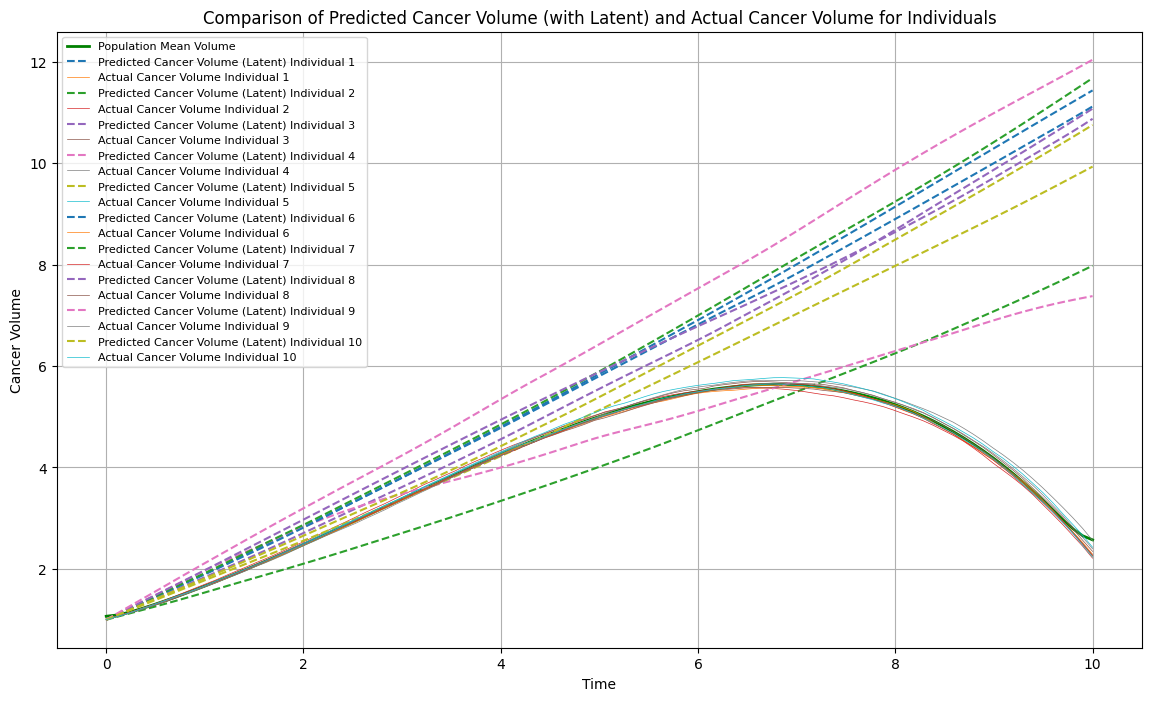

In [55]:
# Function to predict cancer volume from predicted dX/dt values
def predict_cancer_volume_from_dxdt(dX_dt, initial_volume, time_points):
    predicted_volumes = []
    
    for dX in dX_dt:
        def dXdt(t, x):
            return dX[int(np.clip(t, 0, len(dX) - 1))]  # Ensure appropriate indexing

        # Solve the ODE to obtain cancer volume over time
        sol = solve_ivp(dXdt, [time_points[0], time_points[-1]], [initial_volume], t_eval=time_points)
        predicted_volume = sol.y[0]  # Extract the predicted cancer volume
        predicted_volumes.append(predicted_volume)

    return np.array(predicted_volumes)

# Predict dX/dt for all individuals using their inferred betas and ground truth latent values
dX_dt_predicted_latent = predict_dX_dt(results_c, np.mean(results_v, axis=0), individual_betas)

# Now, predict cancer volumes for all individuals
predicted_cancer_volumes_latent = predict_cancer_volume_from_dxdt(dX_dt_predicted_latent, initial_volume=1, time_points=time_points)

# Plotting results for individuals and comparisons between predicted and actual cancer volumes
plt.figure(figsize=(14, 8))

# Plot the mean actual volume
plt.plot(time_points, mean_volume, color='green', linewidth=2, label='Population Mean Volume')

# Plot predictions for all individuals
for i in range(n_individuals):
    plt.plot(time_points, predicted_cancer_volumes_latent[i],
             label=f"Predicted Cancer Volume (Latent) Individual {i + 1}", linestyle='--')
    plt.plot(time_points, results_v[i],
             label=f"Actual Cancer Volume Individual {i + 1}", linewidth=0.5)  # Plot the actual volume

plt.xlabel("Time")
plt.ylabel("Cancer Volume")
plt.title("Comparison of Predicted Cancer Volume (with Latent) and Actual Cancer Volume for Individuals")
plt.legend(fontsize=8)  # You can specify an exact size
plt.grid()
plt.show()

# NO LATENT Approach 

In [56]:
# def generate_pkpd_data(num_individuals, population_params, phi, t):
#     results_concentration = []
#     results_volume = []

#     for _ in range(num_individuals):
#         y0 = [10, 1]  # Initial drug concentration and cancer volume
#         res = solve_ivp(pkpd_model, [t[0], t[-1]], y0, args=(population_params, phi), t_eval=t)
#         results_concentration.append(res.y[0])
#         results_volume.append(res.y[1])

#     results_concentration = np.array(results_concentration)
#     results_volume = np.array(results_volume)

#     return results_concentration, results_volume



In [57]:
# Build feature library for SINDy without latent variables
def build_feature_library_no_latent(X):
    A = np.column_stack([X, X**2])  # Only include X and its square to fit dynamics
    return A

def fit_population_dynamics_sindy(X, Z):
    """ Fit the population dynamics using SINDy approach. """
    A = build_feature_library_no_latent(X)  # Create feature space excluding latent variables
    dX_dt = np.gradient(Z, time_points)  # Calculate dX/dt

    lasso = Lasso(alpha=0.01, fit_intercept=False)
    print(A.shape, dX_dt.shape)
    lasso.fit(A, dX_dt)
    return lasso.coef_  # Returns estimated coefficients for the population model


def fit_population_dynamics_no_latent(t, dX_dt, feature_library):
    """Fit the population dynamics using SINDy approach without latent variables."""
    # dX/dt is the change in cancer volume, we assume Z correlates with this
    Y = dX_dt  # Actual dX/dt from individual data

    lasso = Lasso(alpha=0.01, fit_intercept=False)  # Regularization parameter
    lasso.fit(feature_library, Y)  # Fit the model
    return lasso.coef_

In [58]:
# Fine-tune for individual-specific dynamics using their fitted latent coefficients
def fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library, beta_est, lambda_reg=0.1):
    def loss_function(beta_i):
        mse_loss = np.mean((dX_dt_i - feature_library @ beta_i) ** 2)
        reg_loss = lambda_reg * np.sum((beta_est - beta_i) ** 2)
        return mse_loss + reg_loss

    res = minimize(loss_function, beta_est, method="L-BFGS-B")
    return res.x

In [59]:
def predict_dX_dt_no_latent(X, Z, individual_betas):
    dX_dt_predictions = []
    
    for i, beta_individual in enumerate(individual_betas):
        if len(beta_individual) == 2:
            # Only using the respective X[i] for computation as we don't have latent variables
            dX_dt_i = (beta_individual[0] * X[i] * (1 - X[i] / 10) +
                        beta_individual[1] * Z)
        else:
            # If additional coefficients exist (for debugging, if needed)
            dX_dt_i = (beta_individual[0] * X[i] * (1 - X[i] / 10) +
                        beta_individual[1] * Z +
                        beta_individual[2] * np.sin(np.array(time_points)))  # Fall back to previous behavior

        dX_dt_predictions.append(dX_dt_i)
    
    return np.array(dX_dt_predictions) 

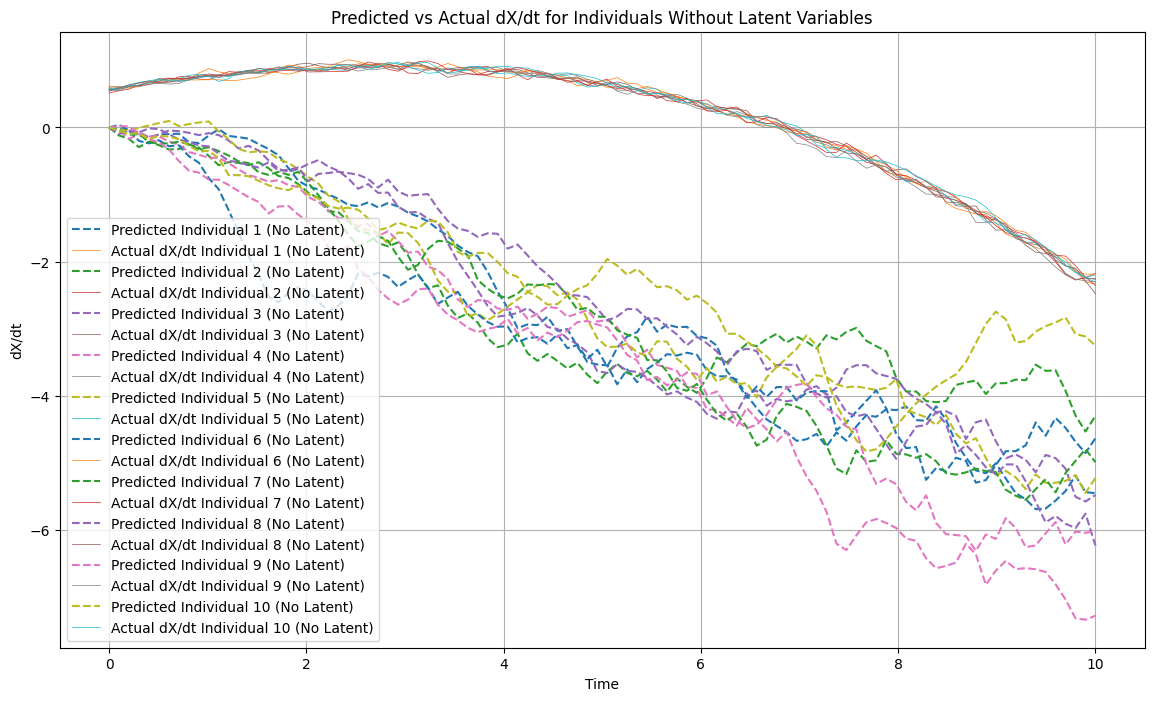

In [60]:
# Generate data with latent variables as before
results_c, results_v, _, _, _ = generate_pkpd_data(n_individuals, population_parameters, phi, time_points)

# Calculate dX/dt for each individual
individual_dX_dt = [np.gradient(results_v[i], time_points) for i in range(n_individuals)]

# Build the feature library without latent variables
feature_libraries_no_latent = [build_feature_library_no_latent(results_c[i]) for i in range(n_individuals)]

# Fit the population-level ODE without latent influence
beta_est_no_latent = fit_population_dynamics_no_latent(time_points, individual_dX_dt[0], feature_libraries_no_latent[0])

# Fine-tune for individual-specific dynamics without latent variables
individual_betas_no_latent = []
for i in range(n_individuals):
    beta_individual_no_latent = fine_tune_individual_dynamics(results_c[i], individual_dX_dt[i], feature_libraries_no_latent[i], beta_est_no_latent)
    individual_betas_no_latent.append(beta_individual_no_latent)

# Print results for each individual
# print('\nIndividual Coefficients (Fitted Without Latent):')
# for i in range(n_individuals):
#     print(f"Individual {i + 1} fitted beta: {individual_betas_no_latent[i]}")

# Predict dX/dt using inferred coefficients for each individual without latent influence
dX_dt_predicted_no_latent = predict_dX_dt_no_latent(results_c, np.zeros(time_points.shape), individual_betas_no_latent)

# Plotting results for individuals and predictions without latent influence
plt.figure(figsize=(14, 8))

# Comparison of predicted and actual dX/dt for individuals without latent influence
for i in range(n_individuals):
    plt.plot(time_points, dX_dt_predicted_no_latent[i], label=f"Predicted Individual {i + 1} (No Latent)", linestyle='--')
    plt.plot(time_points, individual_dX_dt[i], label=f"Actual dX/dt Individual {i + 1} (No Latent)", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("dX/dt")
plt.title("Predicted vs Actual dX/dt for Individuals Without Latent Variables")
plt.legend()
plt.grid()
plt.show()

In [61]:
# Function to calculate Mean Squared Error
def calculate_mse(true_values, predicted_values):
    return np.mean((true_values - predicted_values) ** 2)

# Function to calculate R² (Goodness-of-Fit)
def calculate_r_squared(true_values, predicted_values):
    ss_res = np.sum((true_values - predicted_values) ** 2)  # Residual sum of squares
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)  # R² value

# Compute and print metrics for each individual
mse_values_no_latent = []
r_squared_values_no_latent = []

for i in range(n_individuals):
    # Actual dX/dt for the individual
    actual_dX_dt = individual_dX_dt[i]
    # Predicted dX/dt for the individual
    predicted_dX_dt = dX_dt_predicted_no_latent[i]

    mse = calculate_mse(actual_dX_dt, predicted_dX_dt)
    r_squared = calculate_r_squared(actual_dX_dt, predicted_dX_dt)

    mse_values_no_latent.append(mse)
    r_squared_values_no_latent.append(r_squared)

    print(f"Individual {i + 1} - MSE: {mse:.4f}, R²: {r_squared:.4f}")

# Calculate and print population-level metrics
population_mse_no_latent = calculate_mse(np.concatenate(individual_dX_dt), np.concatenate(dX_dt_predicted_no_latent))
population_r_squared_no_latent = calculate_r_squared(np.concatenate(individual_dX_dt), np.concatenate(dX_dt_predicted_no_latent))

print(f"Population (No Latent) - MSE: {population_mse_no_latent:.4f}, R²: {population_r_squared_no_latent:.4f}")

Individual 1 - MSE: 10.3662, R²: -11.1344
Individual 2 - MSE: 8.8968, R²: -9.6244
Individual 3 - MSE: 9.6161, R²: -10.2145
Individual 4 - MSE: 14.7900, R²: -15.7228
Individual 5 - MSE: 9.3298, R²: -10.0401
Individual 6 - MSE: 11.4492, R²: -12.9160
Individual 7 - MSE: 10.9607, R²: -12.0944
Individual 8 - MSE: 8.6212, R²: -8.8942
Individual 9 - MSE: 13.4355, R²: -14.8797
Individual 10 - MSE: 6.7967, R²: -7.2859
Population (No Latent) - MSE: 10.4262, R²: -11.2983


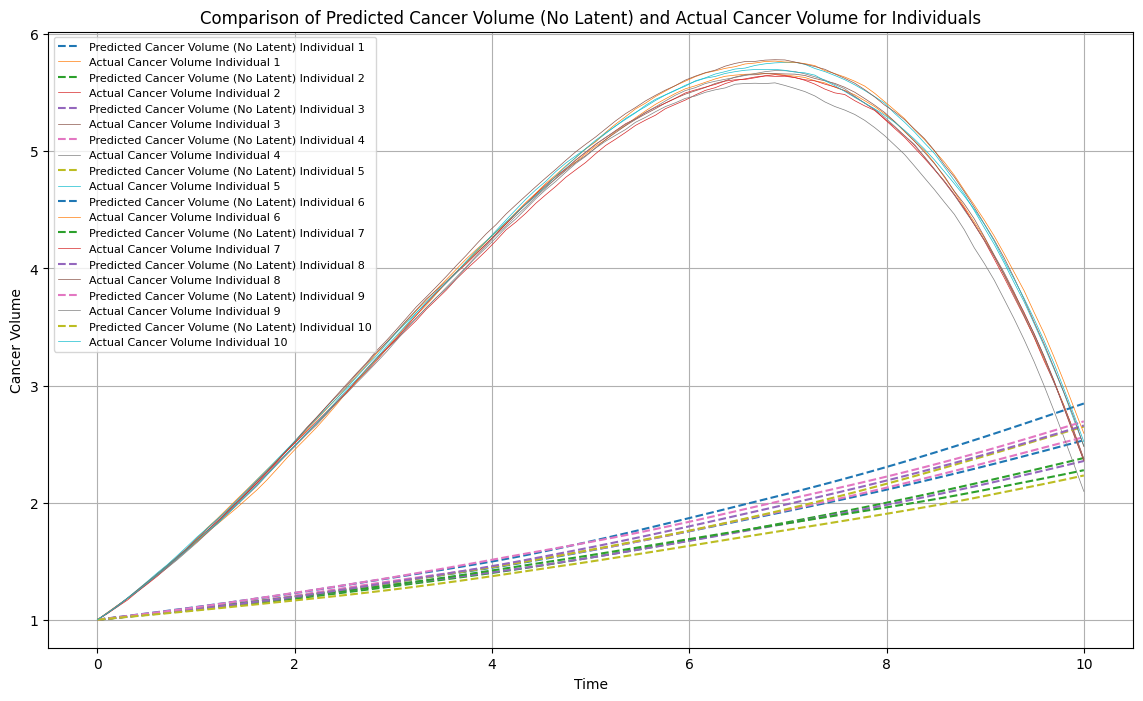

In [62]:
def predict_dX_dt_no_latent(X, individual_betas, concentration_data):
    """Predict dX/dt for all individuals without incorporating latent variables."""
    dX_dt_predictions = []
    
    for i, beta_individual in enumerate(individual_betas):
        # Calculate dX/dt using only the beta coefficients relevant to this model
        C = concentration_data[i]  # Array of drug concentration for individual i
        dX_dt_i = (beta_individual[0] * X[i] * (1 - X[i] / 10) +  # Effect of drug concentration and volume
                    beta_individual[1] * C)  # Direct effect from the coefficient without latent influence
        
        dX_dt_predictions.append(dX_dt_i)
    
    return np.array(dX_dt_predictions)

# Calculate the predicted dX/dt for all individuals using their inferred betas without latent effects
dX_dt_predicted_no_latent = predict_dX_dt_no_latent(results_volume, individual_betas_no_latent, results_concentration)


# Function to predict cancer volume from predicted dX/dt without latent effects
def predict_cancer_volume_no_latent(dX_dt, initial_volume, time_points):
    predicted_volumes = []
    
    for dX in dX_dt:
        def dXdt(t, x):
            return dX[int(np.clip(t, 0, len(dX) - 1))]  # Ensure appropriate indexing

        # Solve the ODE to obtain cancer volume over time
        sol = solve_ivp(dXdt, [time_points[0], time_points[-1]], [initial_volume], t_eval=time_points)
        predicted_volume = sol.y[0]  # Extract the predicted cancer volume from the solution
        predicted_volumes.append(predicted_volume)

    return np.array(predicted_volumes)

# Predict cancer volumes using the predicted dX/dt without latent effects
predicted_cancer_volumes_no_latent = predict_cancer_volume_no_latent(dX_dt_predicted_no_latent, 1, time_points)


# Plotting results for individuals and comparisons between predicted and actual cancer volumes without latent influence
plt.figure(figsize=(14, 8))

for i in range(n_individuals):
    plt.plot(time_points, predicted_cancer_volumes_no_latent[i], 
             label=f"Predicted Cancer Volume (No Latent) Individual {i + 1}", linestyle='--')
    plt.plot(time_points, results_v[i], 
             label=f"Actual Cancer Volume Individual {i + 1}", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("Cancer Volume")
plt.title("Comparison of Predicted Cancer Volume (No Latent) and Actual Cancer Volume for Individuals")
plt.legend(fontsize=8)  # You can specify an exact size
plt.grid()
plt.show()

## Population-level Analysis

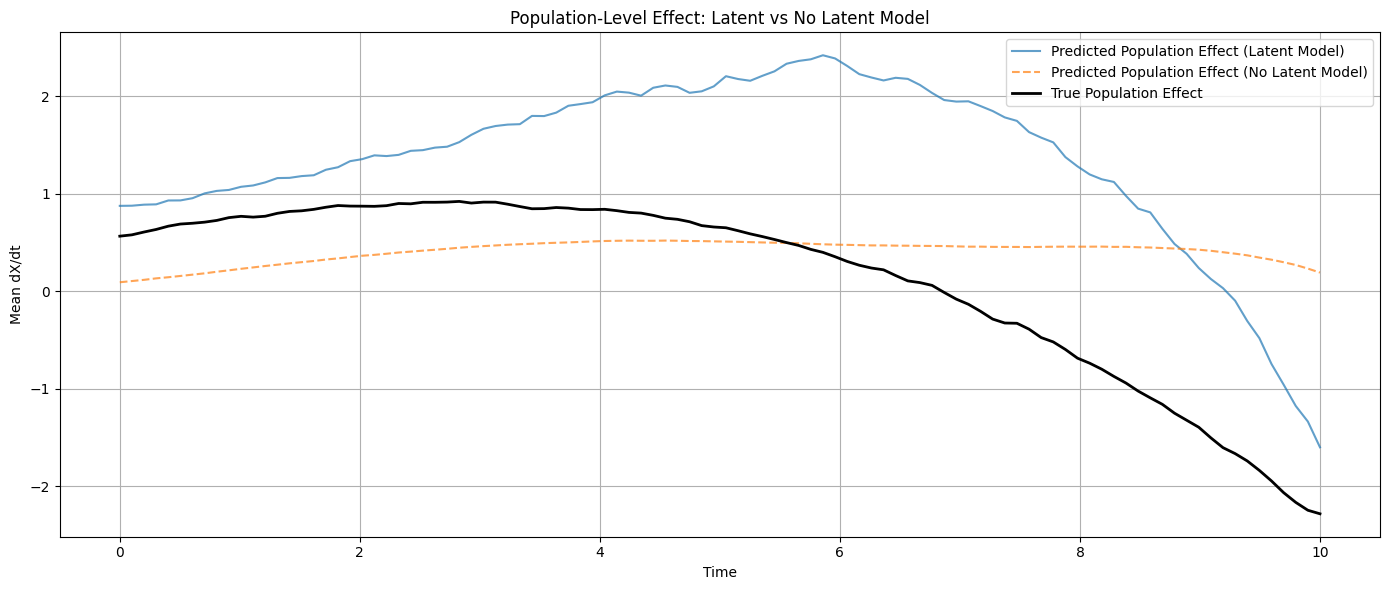

In [63]:
# Generate dX/dt predictions for the population level with latent influence
dX_dt_predicted_with_latent = np.mean(dX_dt_predicted, axis=0)

# Generate dX/dt predictions for the population level without latent influence
dX_dt_predicted_no_latent = np.mean(dX_dt_predicted_no_latent, axis=0)

# Calculate the ground truth dX/dt
dX_dt_ground_truth = np.mean(individual_dX_dt, axis=0)  # Assuming individual_dX_dt is already computed

# Plot: Population-level comparison for latent vs. no latent model
plt.figure(figsize=(14, 6))

# Plot predictions with latent model
plt.plot(time_points, dX_dt_predicted_with_latent, label='Predicted Population Effect (Latent Model)', alpha=0.7)

# Plot predictions with direct model (no latent variables)
plt.plot(time_points, dX_dt_predicted_no_latent, linestyle='--', label='Predicted Population Effect (No Latent Model)', alpha=0.7)

# Plot ground truth
plt.plot(time_points, dX_dt_ground_truth, label='True Population Effect', color='black', linewidth=2)

# Title and labels
plt.title("Population-Level Effect: Latent vs No Latent Model")
plt.xlabel("Time")
plt.ylabel("Mean dX/dt")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()